# Data preparation

Prepare data for further processing.
Steps:
- discretizing data (temporal and spatial)
- encoding of categorical values
- dropping of not necessary columns
- persisting the prepared dataset as 'trips_prepared.hdf5'


In [285]:
import vaex

Load dataset

In [286]:
df_trips = vaex.open("../data/trips/trips.hdf5")

In [287]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip End Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Pickup Census Tract,float64,,,
Dropoff Census Tract,float64,,,
Pickup Community Area,float64,,,
Dropoff Community Area,float64,,,


## Discretize Data

Temporal 

In [288]:
import numpy as np
from datetime import datetime

def convert_to_datetime(date_string):
    return np.datetime64(datetime.strptime(str(date_string), "%m/%d/%Y %I:%M:%S %p"))

df_trips['ts_start']  = df_trips["Trip Start Timestamp"].apply(convert_to_datetime)

In [289]:
# add hourly
df_trips['ts_start_1_hour'] = df_trips['ts_start'].dt.floor('1h')
df_trips['ts_start_4_hour'] = df_trips['ts_start'].dt.floor('4h')
df_trips['ts_start_6_hour'] = df_trips['ts_start'].dt.floor('6h')

df_trips['ts_start_day']    = df_trips['ts_start'].dt.date

df_trips['start_hour']      = df_trips['ts_start'].dt.hour
df_trips['start_weekday']   = df_trips['ts_start'].dt.dayofweek
df_trips['start_month']     = df_trips['ts_start'].dt.month

Spatial

In [290]:
import geopandas as gpd
import h3

gdf = gpd.read_file('../data/hexagon_files/hexagon_res7.geojson')
gdf

# Create a spatial index for faster spatial queries
gdf.sindex
gdf



,geometry
0,"POLYGON ((-87.60234 41.77784, -87.61504 41.769..."
1,"POLYGON ((-87.58507 41.81862, -87.59779 41.810..."
2,"POLYGON ((-87.71166 41.78075, -87.72434 41.772..."
3,"POLYGON ((-87.79835 42.03585, -87.81108 42.027..."
4,"POLYGON ((-87.81162 41.93804, -87.82433 41.929..."
...,...
156,"POLYGON ((-87.59731 41.85506, -87.61003 41.846..."
157,"POLYGON ((-87.65142 41.92360, -87.66416 41.915..."
158,"POLYGON ((-87.80693 42.01539, -87.81965 42.007..."
159,"POLYGON ((-87.67237 41.93964, -87.68511 41.931..."


In [328]:
import h3
from shapely import Polygon 

# docu resolution https://h3geo.org/docs/core-library/restable/

def convert_to_hex_id (lat, lon, resolution):
        hex_id = h3.geo_to_h3(lat, lon, resolution)
        return hex_id if hex_id != "0" else None

def convert_hex_to_polygon(hex):
        polygon = None
        if hex:
               polygon = Polygon(h3.h3_to_geo_boundary(hex, geo_json=True))         
        return polygon


In [329]:
# define multiple convert functions, since vaex_df.apply() only supports column arguments

def convert_to_hex_id_7 (lat, lon):
    return convert_to_hex_id (lat, lon, 7)
def convert_to_hex_id_8 (lat, lon):
    return convert_to_hex_id (lat, lon, 8)
def convert_to_hex_id_9 (lat, lon):
    return convert_to_hex_id (lat, lon, 9)


In [330]:
df_trips['pickup_hex_7']  = df_trips.apply(convert_to_hex_id_7, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_7'] = df_trips.apply(convert_to_hex_id_7, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])
df_trips['pickup_hex_8']  = df_trips.apply(convert_to_hex_id_8, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_8'] = df_trips.apply(convert_to_hex_id_8, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])
df_trips['pickup_hex_9']  = df_trips.apply(convert_to_hex_id_9, arguments=[df_trips['Pickup Centroid Latitude'],  df_trips['Pickup Centroid Latitude']])
df_trips['dropoff_hex_9'] = df_trips.apply(convert_to_hex_id_9, arguments=[df_trips['Dropoff Centroid Latitude'], df_trips['Dropoff Centroid Latitude']])

In [331]:
df_trips['pickup_pol_7']  = df_trips['pickup_hex_7'].apply(convert_hex_to_polygon)
df_trips['dropoff_pol_7'] = df_trips['dropoff_hex_7'].apply(convert_hex_to_polygon)
df_trips['pickup_pol_8']  = df_trips['pickup_hex_8'].apply(convert_hex_to_polygon) 
df_trips['dropoff_pol_8'] = df_trips['dropoff_hex_8'].apply(convert_hex_to_polygon)
df_trips['pickup_pol_9']  = df_trips['pickup_hex_9'].apply(convert_hex_to_polygon) 
df_trips['dropoff_pol_9'] = df_trips['dropoff_hex_9'].apply(convert_hex_to_polygon)

In [332]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip End Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Pickup Census Tract,float64,,,
Dropoff Census Tract,float64,,,
Pickup Community Area,float64,,,
Dropoff Community Area,float64,,,


## Analysis of string attribute sizes, lengths etc. Encoding of string categorical values for further processing

In [169]:
len(df_trips['Payment Type'].unique())

7

In [170]:
df_trips['Payment Type'].unique()

['Dispute', 'Unknown', 'Prcard', 'Cash', 'Credit Card', 'Pcard', 'No Charge']

In [171]:
len(df_trips['Company'].unique())

108

In [172]:
df_trips['Company'].unique()

['3556 - 36214 RC Andrews Cab',
 None,
 '3094 - G.L.B. Cab Co',
 '2823 - Seung Lee',
 '5074 - 54002 Ahzmi Inc',
 '4787 - Reny Cab Co',
 '3253 - 91138 Gaither Cab Co.',
 '0118 - 42111 Godfrey S.Awir',
 '3897 - 57856 Ilie Malec',
 'Blue Ribbon Taxi Association Inc.',
 '585 - Valley Cab Co',
 '4732 - Maude Lamy',
 'Blue Diamond',
 '4615 - 83503 Tyrone Henderson',
 '3385 - Eman Cab',
 'Northwest Management LLC',
 '2733 - Benny Jona',
 '4053 - Adwar H. Nikola',
 '2192 - Zeymane Corp',
 '2767 - Sayed M Badri',
 '4787 - 56058 Reny Cab Co',
 '1408 - Donald Barnes',
 'nan',
 'Flash Cab',
 '3620 - David K. Cab Corp.',
 '6488 - Zuha Taxi',
 '4053 - 40193 Adwar H. Nikola',
 '6743 - 78771 Luhak Corp',
 'Taxi Affiliation Services',
 'Chicago Medallion Management',
 '1408 - 89599 Donald Barnes',
 "3591- 63480 Chuk's Cab",
 'Suburban Dispatch LLC',
 '3385 - 23210  Eman Cab',
 'Chicago Elite Cab Corp. (Chicago Carriag',
 '0694 - 59280 Chinesco Trans Inc',
 '3623 - 72222 Arrington Enterprises',
 '5874 -

In [173]:
len(df_trips['Taxi ID'].unique())

7781

In [174]:
df_trips['Taxi ID'].apply(lambda x : len(x) if x != None else 0).mean()

array(127.99877803)

Encode string columns

In [175]:
def generate_encoding_dict(df, column):
    # get categories to encode
    categories = df[column].unique()
    # generate output the categories are mapped to -> using a simple integer mapping 
    output = range(len(categories))
    # combine categories and output
    encoding_dict = dict(zip(categories, output))
    return encoding_dict

In [176]:
df_trips['Payment Type_encoded'] = df_trips['Payment Type'].map(generate_encoding_dict(df_trips, 'Payment Type'))
df_trips['Company_encoded']      = df_trips['Company'].map(generate_encoding_dict(df_trips, 'Company'))
df_trips['Taxi ID_encoded']      = df_trips['Taxi ID'].map(generate_encoding_dict(df_trips, 'Taxi ID'))

## Drop Trips without spatial data or spaitial data from outside of Chicago
Import of chicago city boundary data from official website

In [261]:
import geopandas as gpd
import shapely 

chicago_polygon = gpd.read_file('../data/trips/Boundaries - City.geojson')
chicago_polygon

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1,6450276623.31,845282.931362,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."


<Axes: >

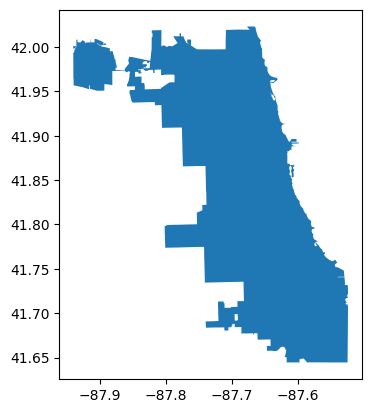

In [185]:
chicago_polygon.plot()

In [278]:
geometries = chicago_polygon.geometry.explode()

hex_inside_boundary = []

for geo in geometries:   
    polygon = shapely.geometry.mapping(geo)
    hex_inside_boundary += h3.polyfill(polygon, 9)

hex_inside_boundary

C:\Users\leoni\AppData\Local\Temp\ipykernel_9464\2590621229.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  geometries = chicago_polygon.geometry.explode()


['89f162d9873ffff',
 '89f162d863bffff',
 '89f162cb5d3ffff',
 '89f162cb16bffff',
 '89f162c98c3ffff',
 '89f175a5d53ffff',
 '89f175a4343ffff',
 '89f162cb1c3ffff',
 '89f162d98cfffff',
 '89f162534b3ffff',
 '89f162c9c43ffff',
 '89f162cb163ffff',
 '89f162cb1c7ffff',
 '89f162c9ea3ffff',
 '89f162c9137ffff',
 '89f162d9813ffff',
 '89f175a595bffff',
 '89f162cb427ffff',
 '89f162cb103ffff',
 '89f162c82c7ffff',
 '89f162cb027ffff',
 '89f162cb153ffff',
 '89f162cb56fffff',
 '89f162c9b5bffff',
 '89f162cb327ffff',
 '89f162d868fffff',
 '89f162cb58bffff',
 '89f162d9863ffff',
 '89f162c864bffff',
 '89f162cb177ffff',
 '89f162c86d7ffff',
 '89f162cb143ffff',
 '89f162d988fffff',
 '89f162d986fffff',
 '89f162cb5c3ffff',
 '89f16253437ffff',
 '89f162cb513ffff',
 '89f162d9877ffff',
 '89f162c9ccbffff',
 '89f162cb54bffff',
 '89f162cb577ffff',
 '89f162c9c4bffff',
 '89f162c82d3ffff',
 '89f162d9c67ffff',
 '89f162c984bffff',
 '89f162d860fffff',
 '89f162cb50bffff',
 '89f162cb0a3ffff',
 '89f162c9c4fffff',
 '89f162c866fffff',


## Drop redundant and not needed columns

Location data is present in different formats. Latitude and Longitude are used in the further processing.
The Trip End Timestamp is dropped as well since the start timestamp and Trip duration are sufficient for the further processing

In [181]:
df_trips.drop(['Pickup Census Tract','Dropoff Census Tract','Pickup Community Area', 'Dropoff Community Area', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Pickup Centroid Location', 'Dropoff Centroid  Location', 'Trip End Timestamp'], inplace=True)

KeyError: "Column or variable 'Pickup Census Tract' does not exist."

## Final dataset

In [180]:
df_trips.info()

column,type,unit,description,expression
Trip ID,str,,,
Taxi ID,str,,,
Trip Start Timestamp,str,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,
Fare,float64,,,
Tips,float64,,,
Tolls,float64,,,
Extras,float64,,,
Trip Total,float64,,,


## Persist dataset as 'trips_prepared.hdf5'

In [14]:
df_trips.export_hdf5("data/trips/trips_prepared.hdf5", progress=True)

export(hdf5) [########################################] 98.90% estimated time:    30.52s =  0.5m =  0.0h                                                                                          